# TC1- CLASIFICACION DE TEXTO CON LOGICA DIFUSA
## Implementación de un Analizador de Relevancia

#### Integrantes del Grupo Nº2
| NOMBRES Y APELLIDOS | CODIGO |ROL|
|:----------|----------|:----------|
| Ambrosio Quispe, Jose Enrique| 19200181 | Integrante|
| Ortiz Abanto, Kevin Miguel| 20200230 | Integrante|
| Pachas Lopez, Nabia Jazmin| 20200231 | Integrante| 
| Retuerto Santillan, Mauro Alejandro| 20200202 | Coordinador|

## Librerias requeridas
A continuación se muestra la importación de módulos y descarga de recursos necesarios para trabajar con procesamiento de lenguaje natural (NLP) en Python.

In [50]:
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
import pandas as pd
import spacy
import nlp
import copy
from googletrans import Translator

nlp = spacy.load("es_core_news_sm")
nltk.download('punkAt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Error loading punkAt: Package 'punkAt' not found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nabia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nabia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Importación del dataset

In [51]:
# Reemplaza 'nombre_del_archivo.csv' con la ruta y nombre de tu archivo CSV
archivo_csv = r'data/Tweets.csv'

# Utiliza Latin-1 como codificación al leer el archivo CSV
df_tweets = pd.read_csv(archivo_csv, delimiter=";", encoding='latin-1')

print(len(df_tweets))

80


## Preprocesamiento del contenido

Esta etapa cuenta con las siguientes fases:
- Eliminación de vocablos no legibles
- Eliminación URL's
- Eliminación Hashtags y Emojis
- Eliminación de Signos de Puntuación
- Normalización
- Tokenización
- Eliminación de Stopwords
- Lematización
- Pasar a Singular

#### Eliminación de vocablos no legibles
Evitar posibles ambiguedades en lo que respecta el texto.

In [52]:
def elim_2vocales(tweet):
    patron = r'\b[a-zA-Z]{2}\b'
    return re.sub(patron,'', tweet)

#### Eliminación de URL's
Eliminar url's (como https://www.canva.com/), y referencias a personas como (@Veronica).

In [53]:
def elim_urls(tweet):
    # Eliminar las urls de un tweet
    res = re.sub(r'http\S+', '', tweet)

    # Eliminar los caracteres especiales
    res = re.sub(r'[^\w\s]', '', res)

    # Eliminar los números
    res = re.sub(r'\d+', '', res)

    # Eliminar las menciones
    res = re.sub(r'@\w+', '', res)

    # Eliminar los espacios en blanco
    res = res.strip()

    return res

#### Eliminación de Hashtags y Emojis
Eliminar simbolo de hashtag # y emojis.

In [54]:
def elim_hash_emojis(tweet):
    #Eliminar hashtags
    res = re.sub(r'#\w+', '', tweet)
    #Eliminar emojis
    res = res.encode('ascii', 'ignore').decode('ascii')
    return res

#### Eliminación de Signos de Puntuación

In [55]:
def elim_punct(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

#### Normalización
Esta técnica se utiliza para conseguir una mayor simplicidad en el texto

In [56]:
def normalize(tweet):
    return tweet.lower()

#### Tokenización

Proceso básico que disemina las oraciones en palabras, para este se hará uso de SpaCy.

In [57]:
def tokenize(tweet):
    return nltk.word_tokenize(tweet)

#### Eliminación de Stopwords
Estas palabras como pueden ser “de”, “el” o “una” son palabras que aparecen con mayor frecuencia y no aportan un significado semántico específico

In [58]:
def elim_stopwords(tokens, languages=['english', 'spanish']):
    stop_words = set()
    
    for lang in languages:
        stop_words.update(set(stopwords.words(lang)))

    return [i for i in tokens if not i in stop_words]

#### Lematización
Esta técnica sirve para reducir variantes morfológicas de la formas de una palabra a raíces comunes o lexemas.

In [59]:
def lematize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Pasar a Singular
Esta técnica sirve para eliminar las palabras en plural y las convierte a singular

In [60]:
def singular(tokens):
    terminaciones = ['ies', 'es', 's']
    for i in range(len(tokens)):
        for a in terminaciones:
            if tokens[i].endswith(a):
                tokens[i] = tokens[i][:-len(a)]
                break
    return tokens

#### Funcion de Preprocesamiento general

Se manda un paramatetro de texto y genera la tokenizacion del tweet en palabras dentro de una lista

In [61]:
def preprocesar(tweet):
    tweet = elim_urls(tweet)
    tweet = elim_hash_emojis(tweet)
    tweet = elim_2vocales(tweet)
    tweet = elim_punct(tweet)
    tweet = normalize(tweet)
    tokens = tokenize(tweet)
    tokens = elim_stopwords(tokens)
    tokens = lematize(tokens)
    tokens = singular(tokens)
    return tokens

## 2. Extraccion de Caracteristicas

Esta etapa cuenta con las siguientes fases:
- Generacion de la bolsa de oraciones
- Identificar las 50 palabras mas frecuentes
- Identificar la funcion de similitud
- Identificar la cantidad de similitud
- Obtener Puntuacion Alta de la Palabra
- Asignar el peso a cada palabra según su nivel de similitud
- Obtener la cantidad de Similaridades
- Obtener la puntuación del jésimo tweet (Fj)
- Obtener la longitud del jésimo tweet (Mj)
- Obtener el número de palabras de uso frecuente en el j-ésimo tweet(Ij)
- Obtener el peso del jésimo tweet (Gj)
- Obtener el peso de las palabras de uso frecuente en el j-ésimo tweet(Ej)

#### Generacion de la bolsa de oraciones

Pasar las oraciones del tweet a una lista.

In [62]:
bolsa_oraciones = []
for tweet in df_tweets['Tweets']:
    bolsa_palabras = preprocesar(tweet)
    oracion = ' '.join(bolsa_palabras)
    bolsa_oraciones.append(oracion)


# Convertir la lista en un DataFrame
df_oraciones = pd.DataFrame({'Tweets': bolsa_oraciones})
print(df_oraciones['Tweets'])

0     people respond threat dont think american need...
1     cute also need covid test mimicshhan wwwweeee ...
2     covid positivity rate stand test positive hmhu...
3     jven ao visto afectado crisi covid adulto nive...
4     hanno chiesto far futuro quarta dose vaccino m...
                            ...                        
75    good time remind people longcovid common young...
76    karnataka government prepared districtwise mic...
77    growth confirmed covid death county latest cov...
78    public health protection dropped glennyoungkin...
79    pour foi parlement vrit sur effetsindesirabl d...
Name: Tweets, Length: 80, dtype: object


#### Identificar las 50 palabras más frecuentes

In [63]:
# Lista de tweets
tweets = []

# Agregar los tweets del DataFrame a la lista tweets
for indice, fila in df_oraciones.iterrows():
    tweet = fila['Tweets']
    tweets.append(tweet)

# Unimos todos los tweets en un solo texto
texto_completo = ' '.join(tweets)

# Tokenizamos el texto
palabras = re.findall(r'\w+', texto_completo.lower())
# Contamos la frecuencia de cada palabra
frecuencia_palabras = Counter(palabras)

# Las 50 palabras más comunes
palabras_comunes = frecuencia_palabras.most_common(50)

palabras = palabras_comunes

arreglo_np = np.array(palabras)


# Obtener los valores de la columna 0 y colocarlos en una lista
columna_0_lista = arreglo_np[:, 0].tolist()

print(columna_0_lista)

['covid', 'de', 'mimicshhan', 'vaccination', 'data', 'death', 'analytic', 'vacina', 'need', 'time', 'vaccine', 'people', 'amp', 'est', 'vaccinated', 'test', 'coronaviru', 'pandemia', 'cute', 'also', 'wwwweeee', 'janeqianhuai', 'connectfarm', 'shhan', 'jven', 'public', 'pour', 'growth', 'confirmed', 'county', 'latest', 'insight', 'team', 'using', 'usafact', 'datavisualization', 'datascience', 'healthtech', 'publichealth', 'globalhealth', 'case', 'prevencin', 'mask', 'july', 'sarscov', 'raison', 'day', 'million', 'citoyen', 'pa']


Conversión a un arreglo.

In [64]:
# Conversión a arreglo numpy
palabras = columna_0_lista
arreglo_np = np.array(palabras)

print(arreglo_np)

['covid' 'de' 'mimicshhan' 'vaccination' 'data' 'death' 'analytic'
 'vacina' 'need' 'time' 'vaccine' 'people' 'amp' 'est' 'vaccinated' 'test'
 'coronaviru' 'pandemia' 'cute' 'also' 'wwwweeee' 'janeqianhuai'
 'connectfarm' 'shhan' 'jven' 'public' 'pour' 'growth' 'confirmed'
 'county' 'latest' 'insight' 'team' 'using' 'usafact' 'datavisualization'
 'datascience' 'healthtech' 'publichealth' 'globalhealth' 'case'
 'prevencin' 'mask' 'july' 'sarscov' 'raison' 'day' 'million' 'citoyen'
 'pa']


Identificar el numero de coincidencias de una palabra en la bolsa de oraciones.

In [65]:
def contar_palabra_en_oracion(oracion, palabra_buscada):
    # Convierte la oración a minúsculas para hacer la búsqueda insensible a mayúsculas/minúsculas
    oracion = oracion.lower()
    # Divide la oración en palabras usando espacios como separadores
    palabras = preprocesar(oracion)
    # Inicializa un contador para llevar un registro de las repeticiones
    contador = 0
    # Itera a través de las palabras y cuenta cuántas veces aparece la palabra buscada
    for palabra in palabras:
        if palabra == palabra_buscada.lower():
            contador += 1
    return contador

#Score
pSup = df_tweets[df_tweets['Score']>=2]
qInf = df_tweets

# Inicializa una lista vacía para almacenar la suma acumulada por palabra
suma_acumulada_por_palabraSup = []

for palabra in palabras:
    sum_acumulada = 0
    for tweet in pSup['Tweets']:
        resultado = contar_palabra_en_oracion(tweet, palabra)
        sum_acumulada += resultado
    suma_acumulada_por_palabraSup.append((palabra, sum_acumulada))  # Agrega la tupla (palabra, suma_acumulada) a la lista

suma_acumulada_por_palabraInf = []

for palabra in palabras:
    sum_acumulada_2 = 0
    for tweet in qInf['Tweets']:
        resultado = contar_palabra_en_oracion(tweet, palabra)
        sum_acumulada_2 += resultado
    suma_acumulada_por_palabraInf.append((palabra, sum_acumulada_2))  # Agrega la tupla (palabra, suma_acumulada) a la lista


# Inicializa una lista vacía para almacenar los resultados de la división
division_resultados = []

if len(suma_acumulada_por_palabraSup) == len(suma_acumulada_por_palabraInf):
    for i in range(len(suma_acumulada_por_palabraSup)):
        palabra_sup, suma_sup = suma_acumulada_por_palabraSup[i]
        palabra_inf, suma_inf = suma_acumulada_por_palabraInf[i]
        
        # Realiza la división y agrega el resultado a la lista de resultados
        if suma_inf != 0:  # Evita la división por cero
            resultado = suma_sup / suma_inf
        else:
            resultado = 0.0
        division_resultados.append((palabra_sup, resultado))
else:
    print("Las listas no tienen la misma longitud")

Ordenar la lista de mayor a menor.

In [66]:
datos = [
    ("covid", 0.898129811),
    ("pandemia", 0.879092244),
    ("coronavirus", 0.866448177),
    ("vacuna", 0.897141422),
    ("cuarentena", 0.705230229),
    ("contagio", 0.760679509),
    ("vacunacion", 0.929045321),
    ("mascarilla", 0.640068648),
    ("distanciamiento", 0.999250856),
    ("muerte", 0.660330467),
    ("variante", 0.875497264),
    ("pcr", 0.922868046),
    ("inmunizacion", 0.880282973),
    ("sintoma", 0.657348412),
    ("hospitalizacion", 0.6733829882),
    ("aislamiento", 0.507508488),
    ("oms", 0.997729725),
    ("emergencia", 0.451805309),
    ("protocolo", 0.994527605),
    ("tratamiento", 0.543998753),
    ("riesgo", 0.576211098),
    ("virus", 0.713434091),
    ("asintomatico", 0.795920826),
    ("minsa", 0.981348133),
    ("resiliencia", 0.747445449),
    ("transmision", 0.881276136),
    ("tasa", 0.979623615),
    ("mortalidad", 0.9041266678),
    ("incidencia", 0.8084302981),
    ("sistema", 0.902776234),
    ("salud", 0.872353904),
    ("crisis", 0.909035916),
    ("desinfectante", 0.987561629),
    ("rastreo", 0.871339403),
    ("ventilador", 0.649354958),
    ("inmunidad", 0.869176727),
    ("cierre", 0.772089406),
    ("prueba", 0.876430908),
    ("desescalada", 0.78452895),
    ("inoculacion", 0.986740817),
    ("critico", 0.984331997),
    ("alarma", 0.836429715),
    ("teletrabajo", 0.518196581),
    ("masa", 0.623441622),
    ("telemedicina", 0.580048225),
    ("uci", 0.927946863),
    ("frontera", 0.95432517),
    ("desinfeccion", 0.717965775),
    ("mensajero", 0.577157196),
    ("experimental", 0.817530041),
    ("reglamento", 0.87569138)
]

# Crear la matriz numpy de tuplas
matriz_tuplas = np.array(datos, dtype=[('palabra', 'U20'), ('frecuencia', float)])


# Ordena la lista de mayor a menor según la tercera columna (índice 2)
keys_L = sorted(matriz_tuplas, key=lambda x: x[1], reverse=True)

Identificar el indice de un tweet segun una lista de palabras

In [67]:
keys_L

[('distanciamiento', 0.99925086),
 ('oms', 0.99772973),
 ('protocolo', 0.99452761),
 ('desinfectante', 0.98756163),
 ('inoculacion', 0.98674082),
 ('critico', 0.984332),
 ('minsa', 0.98134813),
 ('tasa', 0.97962361),
 ('frontera', 0.95432517),
 ('vacunacion', 0.92904532),
 ('uci', 0.92794686),
 ('pcr', 0.92286805),
 ('crisis', 0.90903592),
 ('mortalidad', 0.90412667),
 ('sistema', 0.90277623),
 ('covid', 0.89812981),
 ('vacuna', 0.89714142),
 ('transmision', 0.88127614),
 ('inmunizacion', 0.88028297),
 ('pandemia', 0.87909224),
 ('prueba', 0.87643091),
 ('reglamento', 0.87569138),
 ('variante', 0.87549726),
 ('salud', 0.8723539),
 ('rastreo', 0.8713394),
 ('inmunidad', 0.86917673),
 ('coronavirus', 0.86644818),
 ('alarma', 0.83642971),
 ('experimental', 0.81753004),
 ('incidencia', 0.8084303),
 ('asintomatico', 0.79592083),
 ('desescalada', 0.78452895),
 ('cierre', 0.77208941),
 ('contagio', 0.76067951),
 ('resiliencia', 0.74744545),
 ('desinfeccion', 0.71796578),
 ('virus', 0.71343409

In [68]:
# Cuenta las coincidencias de cada palabra en los tweets con los más frecuentes
def indice_key(palabra):
    i = 1
    for palabra_cmp,nivel in keys_L:
        if palabra == palabra_cmp:
            return i
        i+=1
    else:
        return 0

#### Identificar la funcion de similitud
Se identifica la similitud de una `palabra1` con una `palabra2` y se retorna el valor de similitud el cual está contenido entre 0 y 1.

In [69]:
# Muestra el nivel de similitud entre dos palabras
def similitud(palabra1, palabra2):
    
    # Convierte las palabras en conjuntos de caracteres.
    c_palabra1 = set(palabra1)
    c_palabra2 = set(palabra2)
    
    # Comprueba si una palabra está contenida en la otra.
    if palabra1 in palabra2 or palabra2 in palabra1:
        
        # Calcula la intersección y la unión de los conjuntos de caracteres.
        intersection = len(c_palabra1.intersection(c_palabra2))
        union = len(c_palabra1.union(c_palabra2))
    else:
        # Si las palabras no están relacionadas, devuelve 0.0.
        return 0.0
    
    # Calcula y devuelve el nivel de similitud entre las palabras.
    return intersection / union

#### Identificar la cantidad de similitud

In [70]:
def cant_simil(token_list, keys_L):
    cont = 0  
    
    for palabra in token_list:
        # Itera a través de cada par (palabra clave, puntaje) en la lista de palabras clave.
        
        for key, punt in keys_L:
            # Calcula la similitud entre el token actual y la palabra clave.
            tmp = similitud(palabra, key)
            
            # Si la similitud no es cero, significa que se encontró una coincidencia
            if tmp != 0.0:
                cont = cont + 1
                break  # Rompe el bucle interno para evitar contar más de una vez para el mismo token.
    
    # Si se encontraron tokens similares, se devuelve la cantidad de coincidencias.
    if cont != 0:
        return cont
    else:
        # Si no se encontraron coincidencias, se devuelve un valor predeterminado (en este caso, 1000).
        return 1000

#### Identificar peso de similitud
Asigna el peso a cada palabra según su nivel de similitud.

In [71]:
def funcion_wk(palabra):
    peso_1 = 1
    peso_2 = 0.5
    peso_3 = 0.25

    i = indice_key(palabra)

    if i == 0:
        return 0
    elif 1  <= i < 16:
        return peso_1
    elif 16 <= i < 32:
        return peso_2
    else:
        return peso_3

#### Puntuacion Alta de la Palabra
`funcion_S`: Retorna la puntuación más alta obtenida por una palabra del tweet.

In [72]:
def funcion_S(palabra):
    max = -1
    for clave,t in keys_L:
        nuevo = funcion_wk(clave)*similitud(clave, palabra)
        if(max<nuevo):
            max=nuevo
    return max

#### Puntuación del jésimo tweet 
`funcion_F`: Retorna la suma de puntuaciones de todos las palabras del tweet.

In [73]:
# Retorna la puntuación total del tweet
def funcion_F(tweet):
    suma = 0
    for palabra in tweet:
        suma = suma + funcion_S(palabra)
    return suma

#### Longitud del tweet
`funcion_M`: Retorna la cantidad de palabras del tweet.

In [74]:
# Retorna la longitud del tweet
def funcion_M(tweet):
    return len(tweet)

#### Peso del jésimo tweet
`funcion_G`: Retorna la división entre el valor F y el valor M.

In [75]:
# Retorna el peso del tweet
def funcion_G(tweet,keys_L):
    valor_F = funcion_F(tweet)
    valor_M = cant_simil(tweet,keys_L)
    return valor_F/valor_M

#### Número de palabras de uso frecuente en el j-ésimo tweet
`funcion_I`: Retorna el número de palabras del tweet que están en la lista de palabras más frecuentes

In [76]:
def funcion_I(tweet):
    sum=0
    for palabra in tweet:
        ind = indice_key(palabra)
        if(ind != 0):
            sum = sum + 1
    return sum

#### Peso de las palabras de uso frecuente en el j-ésimo tweet
`funcion_E` Retorna el número de palabras del tweet que están en la lista de palabras más frecuentes.

In [77]:
def funcion_E(tweet,keys_L):
    valor_I=funcion_I(tweet)
    valor_M=cant_simil(tweet,keys_L)
    return valor_I/valor_M

## SISTEMA DE LOGICA DIFUSA

## 1. Importación de Librerías

In [78]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## 2. Diagrama de Bloques

El sistema de inferencia difusa para una emocion cualquiera `Xn` se muestra a continuacion:

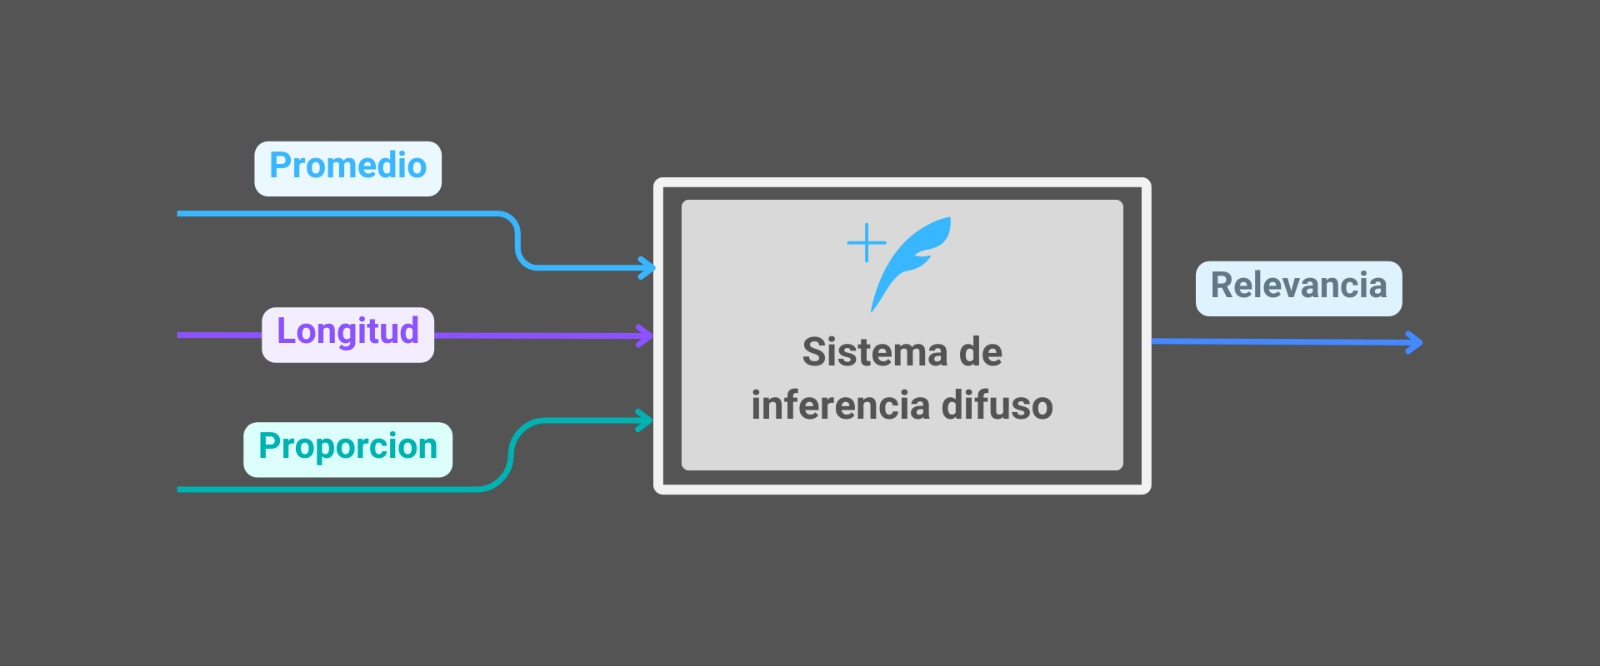

In [79]:
from IPython.display import Image
ruta_imagen = 'LD_clases.jpeg' 
Image(filename=ruta_imagen)

## 3. Variables de entrada y salida

**VARIABLES DE ENTRADA**
- Longitud del Tweet J `(Mj)`

- Peso del tweet J `(Gj)`

- Proporcion de palabras de uso frecuente en el tweet J `(Ej)`

**VARIABLES DE SALIDA**
- Nivel de relevancia del Tweet J `(Rj)`

## 4. Universo, terminos y funciones

### Definición de las variables de entrada

 - Variable linguistica M (tweet_length):
    - Universo de discurso: 0   - 140   
    - Short (bajo)      --> 0   - 18
    - Very Short (bajo) --> 12  - 40
    - Moderate(medio)   --> 30  - 100
    - Long(alto)        --> 80  - 120
    - Very Long (bajo)  --> 110 - 140

 - Variable linguistica G (Tweet Weight):
    - Universo de discurso: 0-1  
    - Very Low  --> 0 - 0.2
    - Low --> 0.1 - 0.4
    - Moderate --> 0.3 - 0.7
    - High --> 0.6 - 0.9
    - Very High --> 0.8 - 1

  - Variable linguistica E (fuw_weight):
    - Universo de discurso: 0-1
    - Low (bajo) --> 0 - 0.12
    - Medium(medio) --> 0.06 -0.23
    - High(alto) --> 0.16 - 1

Definimos el universo para cada variable.

In [80]:
tweet_length = ctrl.Antecedent(np.arange(0, 141, 1), 'M')
tweet_weight = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'G')
fuw_weight = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'E')

### Definición de las funciones de membresía de las variables de entrada
En este fragmento de código, se definen varias variables lingüísticas para su posterior uso en un sistema de lógica difusa. Estas variables representan características relacionadas con la longitud de los tweets, el peso de los tweets y el peso de la frecuencia de uso de palabras en los tweets. Cada variable se divide en varios términos lingüísticos que describen diferentes grados o categorías.

In [81]:
# Variable Tweet Length
tweet_length['Very Short'] = fuzz.trimf(tweet_length.universe, [0, 0, 18])
tweet_length['Short'] = fuzz.trimf(tweet_length.universe, [12, 25, 40])
tweet_length['Moderate'] = fuzz.trimf(tweet_length.universe, [30, 65, 100])
tweet_length['Long'] = fuzz.trimf(tweet_length.universe, [80, 100, 120])
tweet_length['Very Long'] = fuzz.trimf(tweet_length.universe, [110, 140, 140])

# Variable Tweet Weight
tweet_weight['Very Low'] = fuzz.trimf(tweet_weight.universe, [0,0, 0.2])
tweet_weight['Low'] = fuzz.trimf(tweet_weight.universe, [0.1, 0.25, 0.4])
tweet_weight['Moderate'] = fuzz.trimf(tweet_weight.universe, [0.3, 0.5, 0.7])
tweet_weight['High'] = fuzz.trimf(tweet_weight.universe, [0.6, 0.75, 0.9])
tweet_weight['Very High'] = fuzz.trimf(tweet_weight.universe, [0.8, 1, 1])

# Variable Frequency of Use of Words Weight
fuw_weight['Low'] = fuzz.trimf(fuw_weight.universe, [0, 0, 0.12])
fuw_weight['Moderate'] = fuzz.trimf(fuw_weight.universe, [0.06, 0.145, 0.23])
fuw_weight['High'] = fuzz.trimf(fuw_weight.universe, [0.16, 1, 1])

#### Gráficas de las funciones de pertenencia de las variables de entrada
En este fragmento de código, se realizan dos tareas principales:

**1. Definición de Parámetros**
- Se definen tres parámetros que son cruciales para la graficación de las funciones de pertenencia. Estos parámetros son:
  - `variables`: Una lista que contiene las variables lingüísticas (como `tweet_length`, `tweet_weight`, y `fuw_weight).
  - `titles`: Una lista de títulos que describen las variables lingüísticas correspondientes ('Tweet Length', 'Tweet Weight' y 'Frequency of Use of Words Weight').

**2. Graficación de Funciones de Pertenencia**
- Se crea una figura de subtramas utilizando `plt.subplots` para representar gráficamente las funciones de pertenencia de las variables lingüísticas.
- Se itera a través de las variables y títulos utilizando un bucle `for`, donde se toma cada variable y se grafican sus funciones de pertenencia.
- Para cada variable, se genera un conjunto de valores de universo con `np.linspace` y se calcula la membresía en cada término lingüístico utilizando `fuzz.interp_membership`.
- Se grafican las funciones de pertenencia en el espacio de universo.
- Se configuran los títulos, etiquetas de ejes, leyendas y se ajusta el diseño de las subtramas.
- Finalmente, se muestran las subtramas con `plt.show()`.

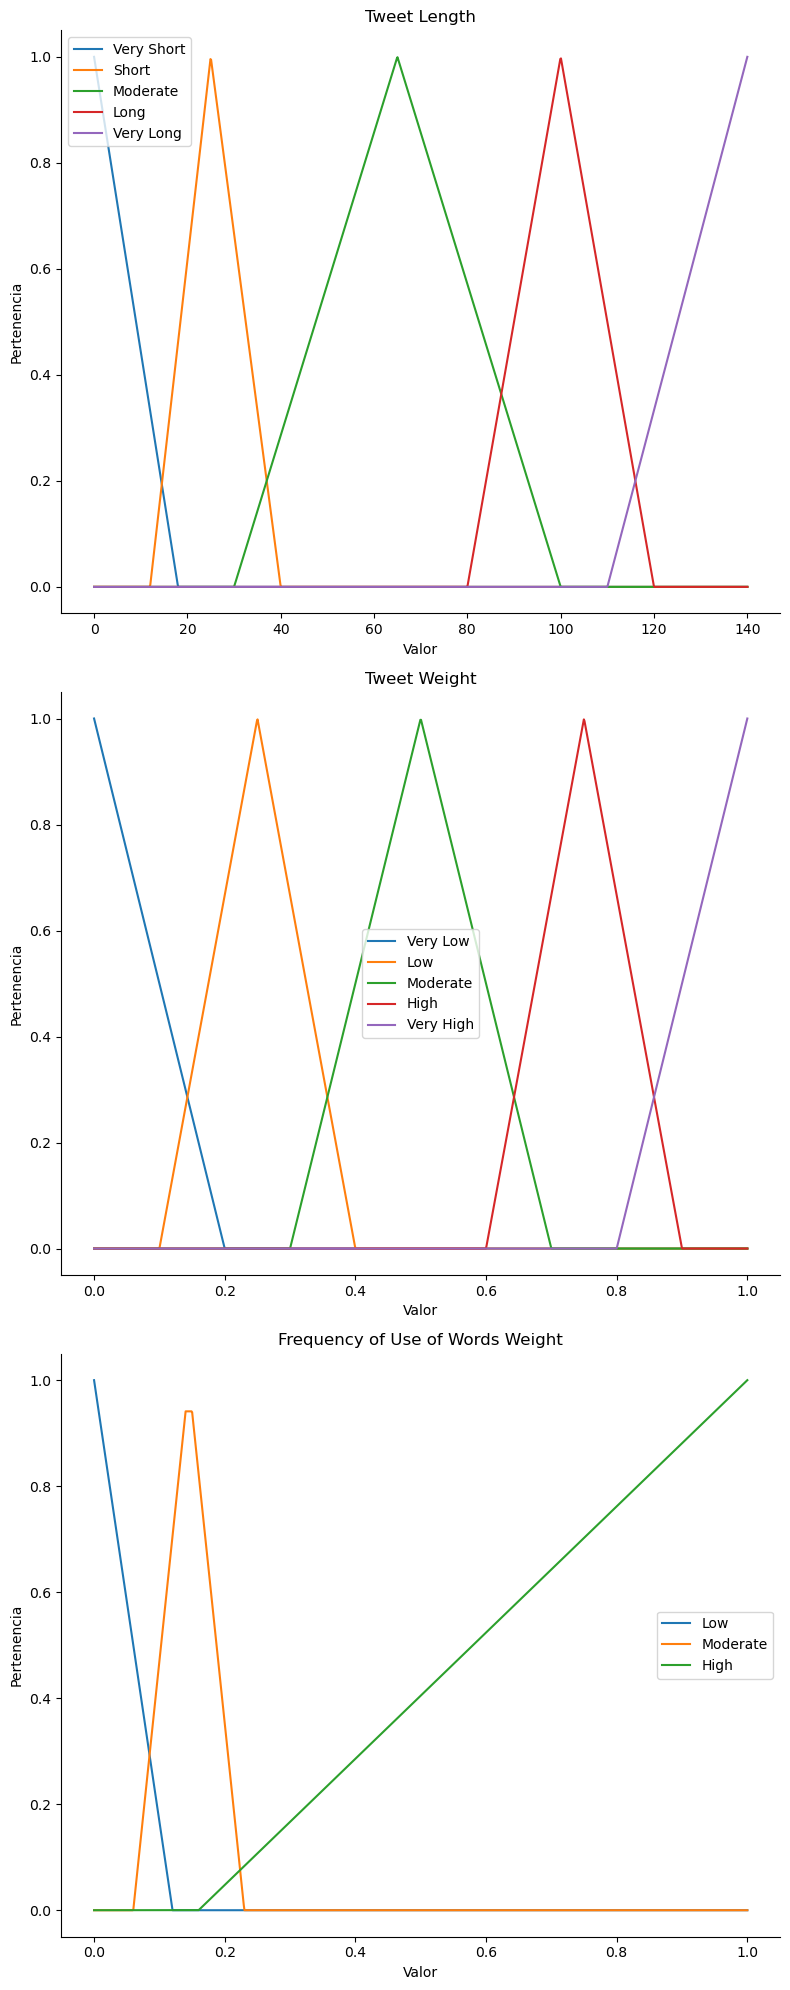

In [82]:
# Definición de los parámetros para las gráficas
variables = [tweet_length, tweet_weight, fuw_weight]
titles = ['Tweet Length','Tweet Weight', 'Frequency of Use of Words Weight']

# Graficar las funciones de pertenencia
fig, axs = plt.subplots(3, 1, figsize=(8, 20))

for ax, variable, title in zip(axs, variables, titles):
    universe = np.linspace(variable.universe.min(), variable.universe.max(), 1000)
    
    for label in variable.terms:
        membership = fuzz.interp_membership(variable.universe, variable[label].mf, universe)
        ax.plot(universe, membership, label=label)
    
    ax.set_title(title)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Pertenencia')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()

### Definición de la variable de salida

- Variable linguistica R:
    - Universo de discurso: 0-100
    - Irrelevance/DK  --> 0 - 30
    - Low Relevance --> 20 - 50
    - Moderate Relevance --> 40 - 70
    - High Relevance --> 65 - 90
    - Very High Relevance --> 80 - 100

In [83]:
relevance = ctrl.Consequent(np.arange(0, 100.1, 0.1), 'R')

### Definición de las funciones de membresía de la variable de salida

In [84]:
# Variable Relevance
relevance['Irrelevance/DK'] = fuzz.trapmf(relevance.universe, [0, 0, 10,30])
relevance['Low Relevance'] = fuzz.trapmf(relevance.universe, [20, 30, 40,50])
relevance['Moderate Relevance'] = fuzz.trapmf(relevance.universe, [40, 50,60,70])
relevance['High Relevance'] = fuzz.trapmf(relevance.universe, [60, 70, 80,90])
relevance['Very High Relevance'] = fuzz.trapmf(relevance.universe, [80, 90,100,100])

#### Gráfica de las funciones de membresía de la variable de salida

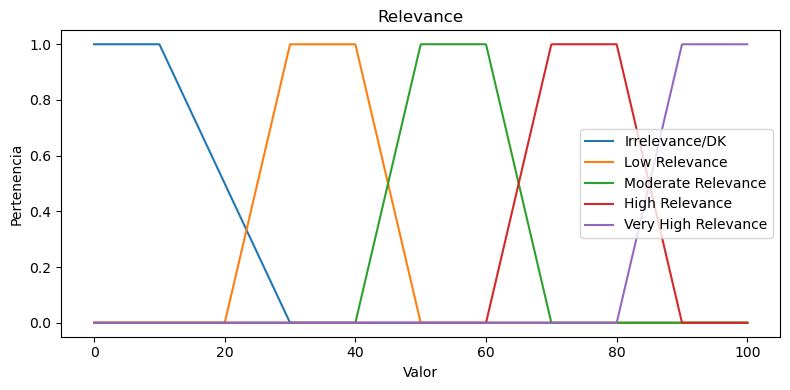

In [85]:
plt.figure(figsize=(8, 4))

universe_relevance = np.linspace(relevance.universe.min(), relevance.universe.max(), 1000)

for label in relevance.terms:
    membership = fuzz.interp_membership(relevance.universe, relevance[label].mf, universe_relevance)
    plt.plot(universe_relevance, membership, label=label)

plt.title('Relevance')
plt.xlabel('Valor')
plt.ylabel('Pertenencia')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Creacion de Reglas
A continuación se muestra la base de reglas del sistema de inferencía difuso.

In [86]:
rule0 = ctrl.Rule(tweet_length['Very Short'], relevance['Irrelevance/DK'])
rule1 = ctrl.Rule(tweet_weight['Very Low'], relevance['Irrelevance/DK'])

rule2 = ctrl.Rule(tweet_weight['Low']&fuw_weight['Low'], relevance['Irrelevance/DK'])
rule3 = ctrl.Rule(tweet_weight['Low']&(fuw_weight['Moderate']|fuw_weight['High']), relevance['Low Relevance'])

rule4 = ctrl.Rule(tweet_weight['Moderate'] &fuw_weight['Low'], relevance['Low Relevance'])
rule5 = ctrl.Rule(tweet_weight['Moderate'] &(fuw_weight['Moderate']|fuw_weight['High'])& (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['Moderate Relevance'])


rule6 = ctrl.Rule(tweet_weight['High'] & fuw_weight['Low']& (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['Moderate Relevance'])
rule7 = ctrl.Rule(tweet_weight['High'] &(fuw_weight['Moderate']|fuw_weight['High'])& (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['High Relevance'])


rule8 = ctrl.Rule(tweet_weight['Very High'] & fuw_weight['Low']& (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['Moderate Relevance'])
rule9 = ctrl.Rule(tweet_weight['Very High'] & fuw_weight['Moderate']& (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['High Relevance'])
rule10 = ctrl.Rule(tweet_weight['Very High'] & fuw_weight['High'] & (tweet_length['Short']|tweet_length['Moderate']|tweet_length['Long']|tweet_length['Very Long']), relevance['Very High Relevance'])


## 6. Caso de Uso
Crear el `ControlSystem` y probar con un tweet de ejemplo.

In [87]:
# Creación del sistema de control
system = ctrl.ControlSystem([rule0, rule1, rule2, rule3, rule4, rule5,rule6, rule7, rule8, rule9,rule10])

# Simulación del sistema de control
simulation = ctrl.ControlSystemSimulation(system)

In [88]:
tweet = "La salud a favor del covid19 produce una serie de amenazas contra la humanidad, la importancia de la vacunacion es una situacion que apremia en las autoridades #Vacunate #Vamos #Minsa"
tweetFinal = preprocesar(tweet)

# Asigna valores de entrada
print('Función M: ', funcion_M(tweetFinal))
print('Función G: ', funcion_G(tweetFinal,keys_L))
print('Función E: ', funcion_E(tweetFinal,keys_L))

Función M:  15
Función G:  0.6714285714285715
Función E:  0.8


Irrelevante:  0.0
Baja relevancia:  0.052473193061292986
Moderada relevancia:  0.947526806938707
Alta relevancia:  0.0
Muy alta relevancia:  0.0


C:\Users\Nabia\AppData\Roaming\Python\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


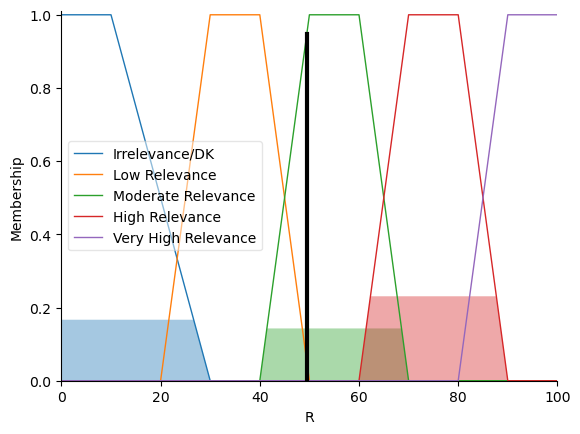

In [89]:
# Asigna valores de entrada
simulation.input['G'] = funcion_G(tweetFinal,keys_L)
simulation.input['E'] = funcion_E(tweetFinal,keys_L)
simulation.input['M'] = funcion_M(tweetFinal)

# Ejecuta la simulación
simulation.compute()

# Obtiene el resultado
resultado = simulation.output['R']

# Grados de relevancia
r_not = fuzz.interp_membership(relevance.universe, relevance['Irrelevance/DK'].mf, resultado)
r_low = fuzz.interp_membership(relevance.universe, relevance['Low Relevance'].mf, resultado)
r_mod = fuzz.interp_membership(relevance.universe, relevance['Moderate Relevance'].mf, resultado)
r_high = fuzz.interp_membership(relevance.universe, relevance['High Relevance'].mf, resultado)
r_vvh = fuzz.interp_membership(relevance.universe, relevance['Very High Relevance'].mf, resultado)

print("Irrelevante: ", r_not)
print("Baja relevancia: ", r_low)
print("Moderada relevancia: ", r_mod)
print("Alta relevancia: ", r_high)
print("Muy alta relevancia: ", r_vvh)

# Grafica la variable de salida
relevance.view(sim=simulation)

Visualizamos el resultado:

In [90]:
resultado 

49.47526806938707